## Семинар: различные имплементации градиентного бустинга

* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

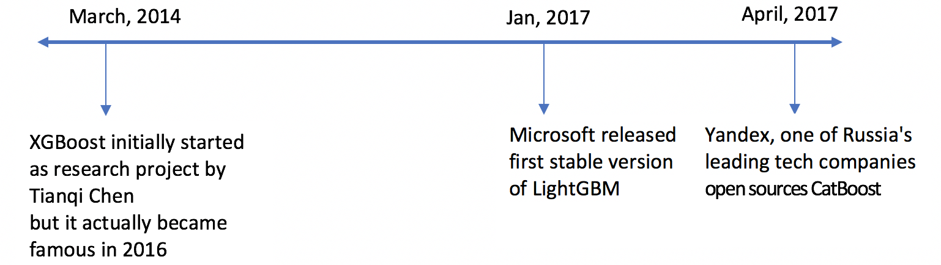!["История"](bst.png)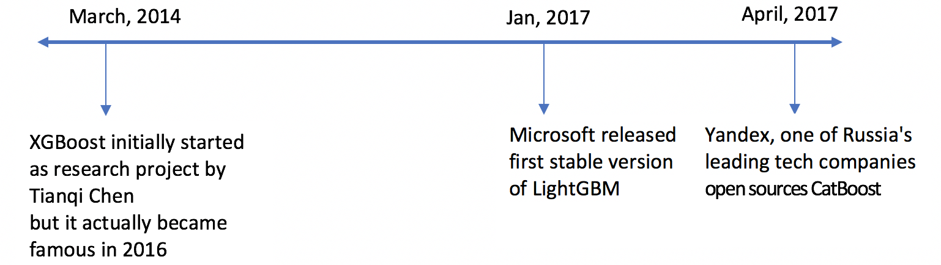

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Будем решать задачу классификации: по различным характеристикам клиента попытаемся определить, выплатит клиент долг или нет.

In [39]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://raw.githubusercontent.com/KSTSV/DA_9_machine_learning/refs/heads/main/lec_sem_10/train_modified.csv')
X_train = df.iloc[:24365]
X_test = df.iloc[24365:24366+10443]
len(X_train), len(X_test)

(24365, 10444)

In [ ]:
X_train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,age,EMI_Loan_Submitted_missing,...,Var1_16,Var1_17,Var1_18,Var2_0,Var2_1,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6
0,0.0,0.0,0,300000.0,5.0,20000,1,0,41.713895,1,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,2,200000.0,2.0,35000,3,13,34.338125,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0.0,5,600000.0,4.0,22500,1,0,38.329911,1,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.0,6,1000000.0,5.0,35000,3,10,32.191650,1,...,0,0,0,0,1,0,0,0,0,0
4,0.0,25000.0,7,500000.0,2.0,100000,3,17,35.975359,1,...,0,0,0,0,1,0,0,0,0,0


Для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры.

Алгоритм подбора гиперпараметров следующий:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [ ]:
target='Disbursed'
IDcol = 'ID'

In [ ]:
X_train['Disbursed'].value_counts(), len(X_train)

(Disbursed
 0.0    23989
 1.0      376
 Name: count, dtype: int64,
 24365)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance

In [ ]:
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Начинаем последовательный подбор параметров при большом learning_rate

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'

Перебираем max_depth и min_child_weight по сетке.

In [ ]:
[i for i in range(2,7,2)]

[2, 4, 6]

In [ ]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train[predictors],X_train[target])

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8200807732625173)

Уточняем предсказание

In [ ]:
param_test2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3, 4]
}

gsearch2 = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train[predictors],X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 4}, 0.8202061097371702)

Зафиксируем найденный max_depth и min_child_weight

In [ ]:
model_xgb.max_depth = 5
model_xgb.min_child_weight = 3

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [ ]:
param_test3 = {
    'gamma': range(0, 3, 1)# your code here
}

gsearch3b = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train[predictors],X_train[target])

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

Установите в качестве параметра алгоритма подобранyю gamma и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
# your code here

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
# your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here

modelfit(model_xgb, X_train, X_test, predictors)

## 2. CatBoost

Оригинальный ноутбук здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [24]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and

In [25]:
from matplotlib import pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [26]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [27]:
(train_df, test_df) = catboost.datasets.amazon()

In [28]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Готовим данные

In [29]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Создаем список категориальных фичей

In [30]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [31]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Способы создать Pool - объект, содержащий матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [32]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3: ' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names())
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [34]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Печать результатов

In [35]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 76.2ms	remaining: 686ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 164ms	remaining: 655ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 210ms	remaining: 490ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 277ms	remaining: 415ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 324ms	remaining: 324ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 365ms	remaining: 243ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 382ms	remaining: 164ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 399ms	remaining: 99.7ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 413ms	remaining: 45.9ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 427ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Визуализация метрик

In [36]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [37]:
model1 = CatBoostClassifier(
    learning_rate=0.1,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.1'
)

model2 = CatBoostClassifier(
    learning_rate=0.07,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.07'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [38]:
from catboost import MetricVisualizer

MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

Оптимальное количество деревьев

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

Кросс-валидация

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

In [ ]:
cv_data.head()

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print(model_with_early_stop.tree_count_)

In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

In [ ]:
print(model_with_early_stop.tree_count_)

Вычисление метрик качества и выбор порога принятия решения

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

Получение предсказаний

In [ ]:
print(model.predict_proba(X_validation))

In [ ]:
print(model.predict(X_validation))

Последовательные предсказания

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Важность признаков

In [ ]:
model.get_feature_importance(prettified=True)

### Shap values

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [ ]:
import shap

shap_values = model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

In [ ]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Сохранение модели

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

Подбор гиперпараметров

In [ ]:
cat = CatBoostClassifier(n_estimators=50)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

In [ ]:
grid_search_result['params']

Визуализация деревьев

In [ ]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [ ]:
cat.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
# !conda install lightgbm --y

# For those who strugle with M1/M2 macs:
# !arch -arm64 brew install libomp

In [ ]:
# pip install lightgbm

In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

import numpy as np

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=100, random_state=241)

Обучение

In [ ]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Можно задать любую (придумать свою, например) метрику качества

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Подбор гиперпараметров

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)**0.5